In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

best_exp = rs.get_best_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    device="cuda"
)
best_exp.build_dataloader()

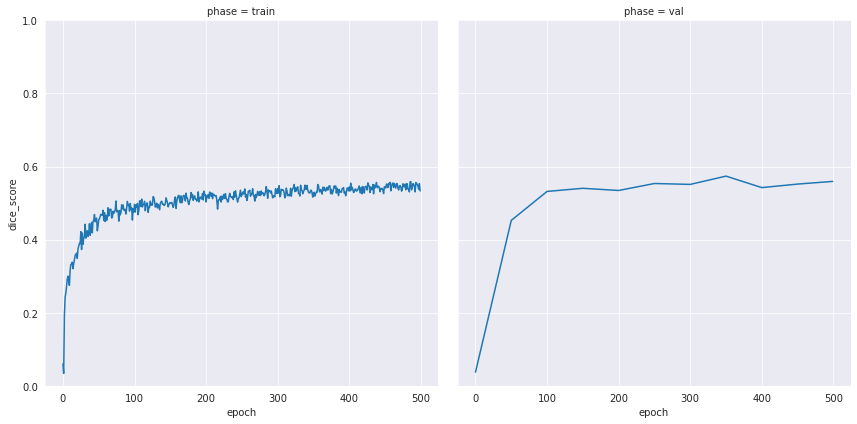

In [4]:
best_exp.vis_loss_curves(height=6)

In [5]:
from ese.experiment.analysis.inference import get_dataset_perf 

# val_perf is a dict where each item is the subj id
predictions_list = get_dataset_perf(
    exp=best_exp, 
    split="val"
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
from ese.experiment.analysis.inference import get_pixelinfo_df

pixel_preds_df = get_pixelinfo_df(predictions_list)

  0%|          | 0/15 [00:00<?, ?it/s]

## Distribution of Pixel Confidences

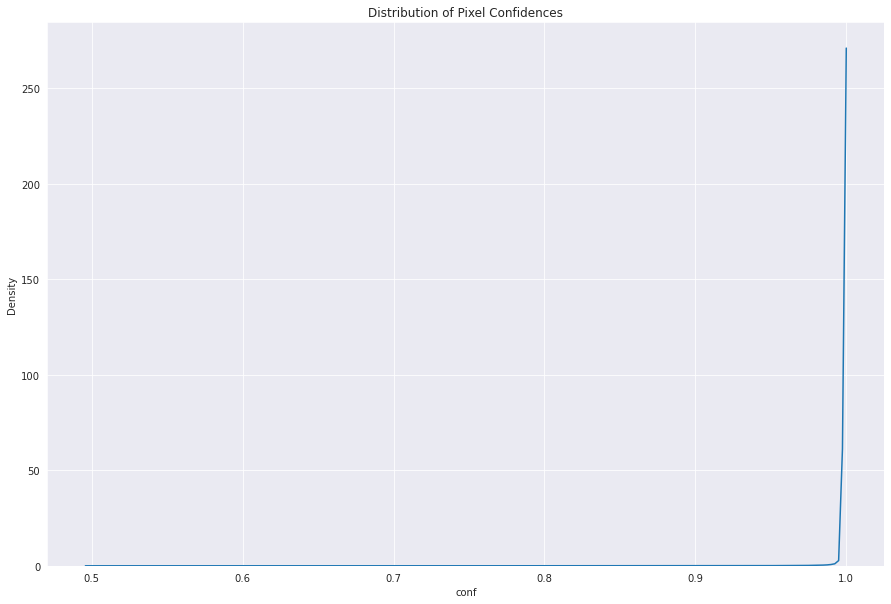

In [7]:
plt.figure(figsize=(15, 10))  # Adjust the width and height as needed
g = sns.kdeplot(data=pixel_preds_df, x="conf", clip=(0, 1))
g.set_title("Distribution of Pixel Confidences")
plt.show()

## Distribution of Pixel Accuracies

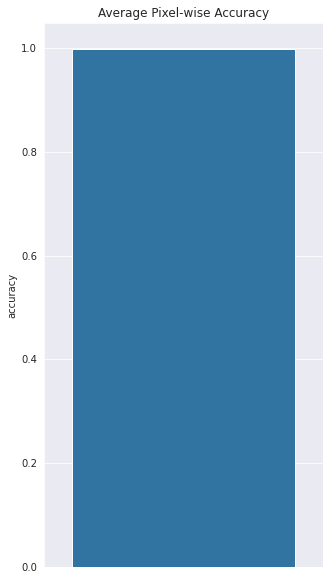

In [8]:
plt.figure(figsize=(5, 10))  # Adjust the width and height as needed
g = sns.barplot(data=pixel_preds_df, y="accuracy")
g.set_title("Average Pixel-wise Accuracy")
plt.show()

In [9]:
pixel_preds_df['conf'].unique()

array([0.9930416 , 0.9998386 , 0.9999677 , ..., 0.99610555, 0.9968757 ,
       0.9968084 ], dtype=float32)

## Distribution of Pixel Confidences vs Label 

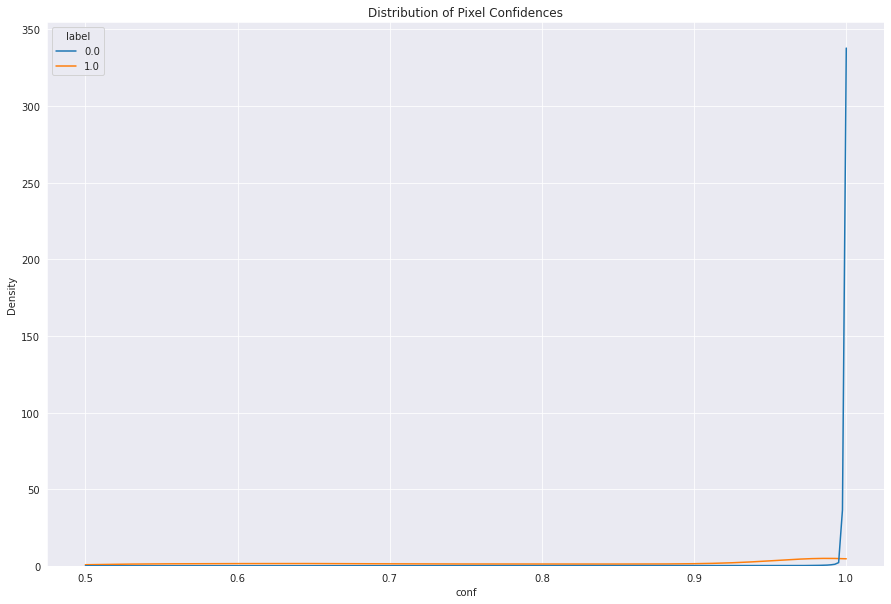

In [10]:
plt.figure(figsize=(15, 10))  # Adjust the width and height as needed
g = sns.kdeplot(data=pixel_preds_df, x="conf", hue="label", common_norm=False, clip=(0.5, 1))
g.set_title("Distribution of Pixel Confidences")
plt.show()

## Distribution of Pixel Accuracies vs Label 

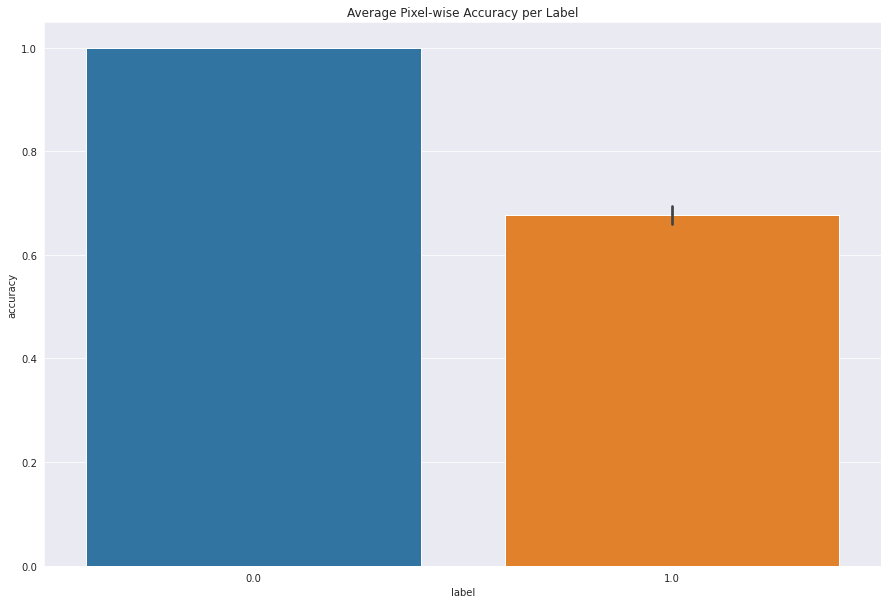

In [11]:
plt.figure(figsize=(15, 10))  # Adjust the width and height as needed
g = sns.barplot(data=pixel_preds_df, x="label", y="accuracy")
g.set_title("Average Pixel-wise Accuracy per Label")
plt.show() 


## Distribution Predicted Region Sizes Over Images. 

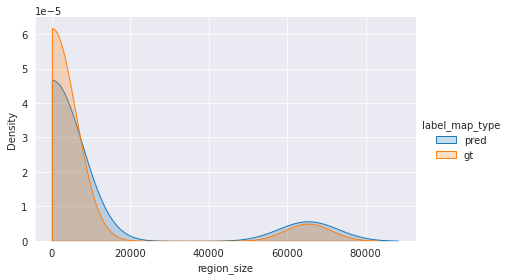

In [12]:
from ese.experiment.analysis.err_diagrams import viz_region_size_distribution

viz_region_size_distribution(
    data_points=predictions_list,
    hue="label_map_type"
)

For label = 0.0


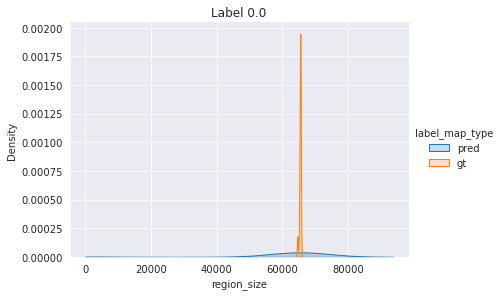

For label = 1.0


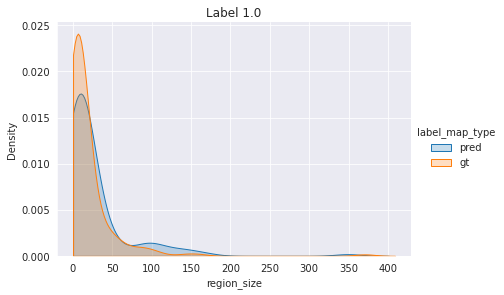

In [13]:
from ese.experiment.analysis.err_diagrams import viz_region_size_distribution

viz_region_size_distribution(
    data_points=predictions_list,
    hue="label_map_type",
    row_split="label"
)

## Distribution of Pixel Accuracies vs Distance to a Boundary

<Axes: xlabel='dist_to_boundary', ylabel='accuracy'>

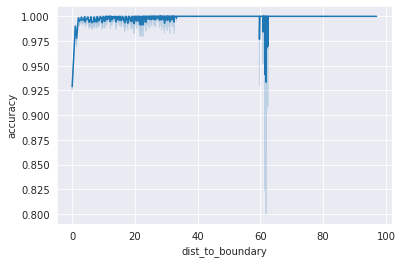

In [14]:
sns.lineplot(data=pixel_preds_df, x="dist_to_boundary", y="accuracy")

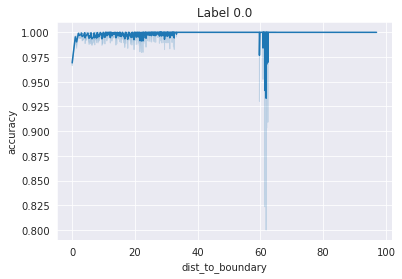

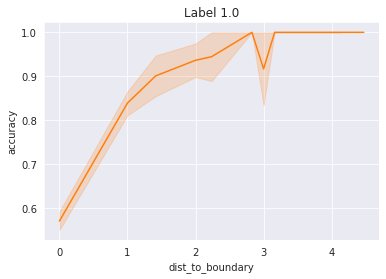

In [15]:
unique_labels = pixel_preds_df['label'].unique()
color_dict = {
    0.0: "blue",
    1.0: "orange"
}
for l_idx, lab in enumerate(unique_labels):
    sns.lineplot(
        data=pixel_preds_df[pixel_preds_df['label']==lab], 
        x="dist_to_boundary", 
        y="accuracy",
        color=sns.color_palette("tab10")[l_idx]
        )
    plt.title(f"Label {lab}")
    plt.show()

## Distribution Pixel Accuracies vs Predicted Size of Region (that pixel is in)

<Axes: xlabel='group_size', ylabel='accuracy'>

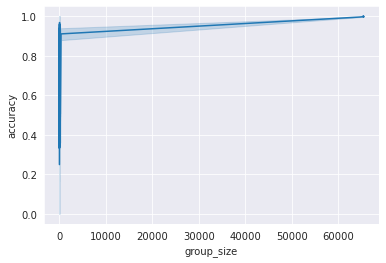

In [16]:
sns.lineplot(data=pixel_preds_df, x="group_size", y="accuracy")

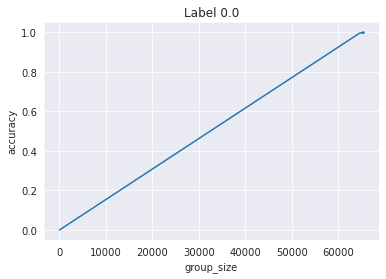

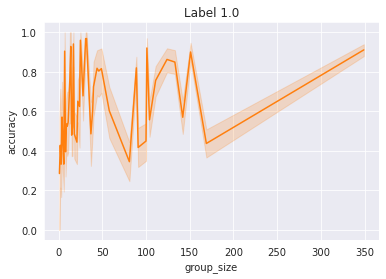

In [17]:
unique_labels = pixel_preds_df['label'].unique()
for l_idx, lab in enumerate(unique_labels):
    sns.lineplot(
        data=pixel_preds_df[pixel_preds_df['label']==lab],
        x="group_size", 
        y="accuracy",
        color=sns.color_palette("tab10")[l_idx]
        )
    plt.title(f"Label {lab}")
    plt.show()

## Super Weird Plot Time: Distance to Boundary vs Parent Size, hue accuracy

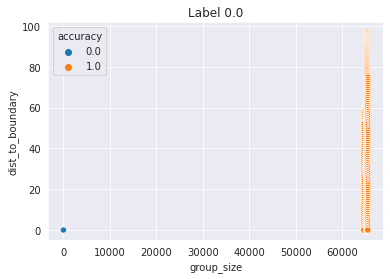

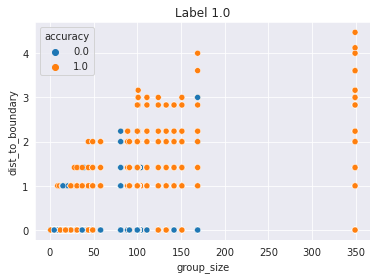

In [18]:
unique_labels = pixel_preds_df['label'].unique()
for l_idx, lab in enumerate(unique_labels):
    sns.scatterplot(
        data=pixel_preds_df[pixel_preds_df['label']==lab],
        x="group_size", 
        y="dist_to_boundary",
        hue="accuracy"
        )
    plt.title(f"Label {lab}")
    plt.show()

## From ToySquare, we want to look at dist to boundary vs (confidence) and (accuracy) on the same plot.j

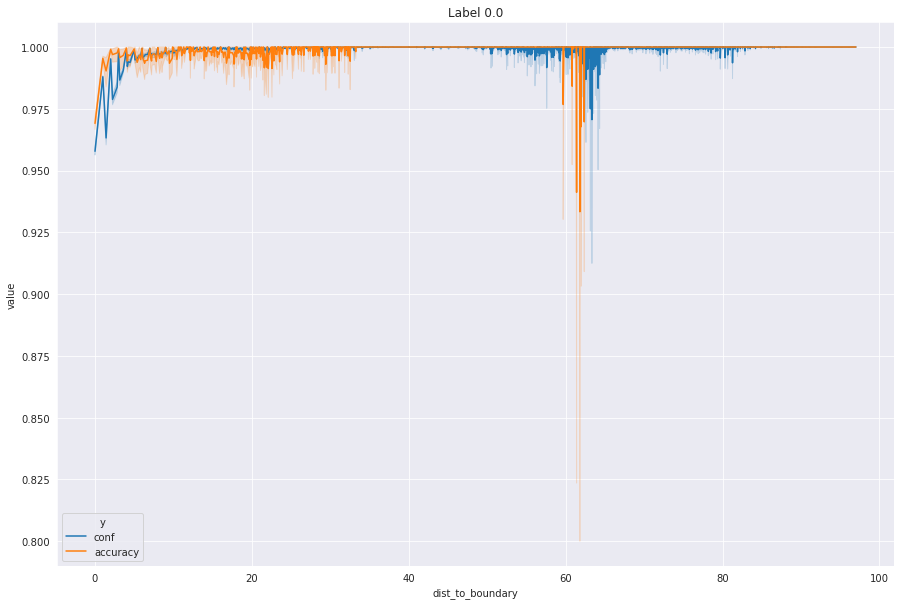

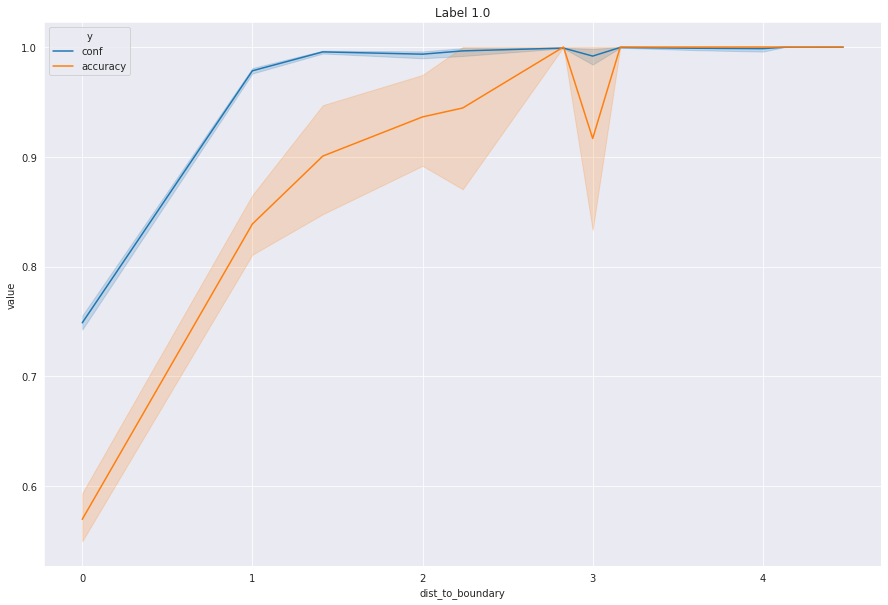

In [19]:
unique_labels = pixel_preds_df['label'].unique()
color_dict = {
    0.0: "blue",
    1.0: "orange"
}
for l_idx, lab in enumerate(unique_labels):
    plt.figure(figsize=(15, 10))  # Adjust the width and height as needed
    label_df = pixel_preds_df[pixel_preds_df['label']==lab]
    label_df_melted = label_df.melt(id_vars='dist_to_boundary', value_vars=['conf', 'accuracy'], var_name='y', value_name='value')
    sns.lineplot(
        data=label_df_melted,
        x="dist_to_boundary", 
        y="value",
        hue='y'
        )
    plt.title(f"Label {lab}")
    plt.show()